In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.max_rows=2000
pd.set_option('display.max_columns', None)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, linewidth=200, edgeitems=100)

# Pipeline and column transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Data transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Data splitter and model evaluator
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, GridSearchCV

# Learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor  # Need to install

# Performance metrics
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve



In [3]:
# --- Matplotlib global font settings -----------------------------------------
plt.rcParams.update({
    'font.size': 14,          # base font
    'axes.titlesize': 20,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
})

In [4]:
#with clusters
file_path = 'student8/s8.xlsx'
df = pd.read_excel(file_path, dtype={"outcome": str})


In [5]:
# Fill NaN values in the 'Session' and 'Start Time' columns with the previous non-null value
df['session'] = df['session'].ffill()
df['start_time'] = df['start_time'].ffill()

### missing values

In [6]:
blank_summary = df.isnull().sum()
blank_summary = blank_summary[blank_summary > 0]  # Filter columns with missing values only
print(blank_summary)

end_time                 22003
Duration (min:sec)       22003
Score                    22003
Points                   22003
skill_specified_time         5
ans_time_ratio               5
deltaPI_skill_future1     1125
deltaPI_skill_future2     2250
deltaPI_skill_past1       1125
deltaPI_skill_past2       2250
deltaPI_day_future1        850
deltaPI_day_past1          850
deltaPI_score_future1        1
dtype: int64


In [7]:
# List of columns to check for NaN
cols_to_check = [
    'skill_specified_time',         
    'ans_time_ratio',               
    'deltaPI_skill_future1',    
    'deltaPI_skill_future2',     
    'deltaPI_skill_past1',      
    'deltaPI_skill_past2',      
    'deltaPI_day_future1',        
    'deltaPI_day_past1',       
    'deltaPI_score_future1'        
]

# Drop rows with NaN in any of the specified columns
df = df.dropna(subset=cols_to_check).reset_index(drop=True)

In [8]:
df['signal_skill_4'] = df[["deltaPI_skill_future1", "deltaPI_skill_past1", "deltaPI_skill_future2", "deltaPI_skill_past2"]].sum(axis=1)

In [9]:
# add a new column EMA of num_signal_4 with span=10
df['ema_signal_4'] = df['signal_skill_4'].ewm(alpha=0.3, adjust=False).mean()


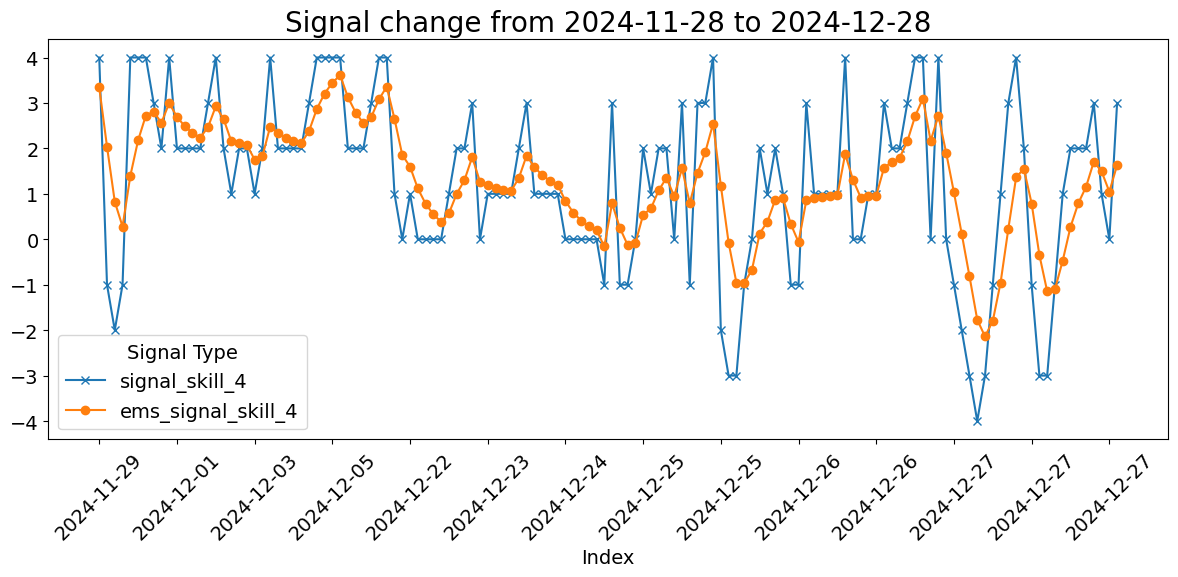

In [10]:
import matplotlib.pyplot as plt
import numpy as np

start = "2024-11-28"
end = "2024-12-28"

df_interval = df[(df["start_time"] >= start) & (df["start_time"] < end)]


plt.figure(figsize=(12, 6))

plt.plot(df_interval.index, df_interval["signal_skill_4"], marker='x', label="signal_skill_4")
plt.plot(df_interval.index, df_interval["ema_signal_4"], marker='o', label="ems_signal_skill_4")
#plt.plot(df_interval.index, df_interval["num_signal_4_skill_0"], marker='x', label="num_signal_4_skill_0")
#plt.plot(df_interval.index, df_interval["deltaPI_day_5min"], marker='*', label="'progress_next_5min")

plt.xlabel("Index")
#plt.ylabel("Number")
plt.title(f"Signal change from {start} to {end}")

# Set integer ticks for x and y axes
# integer tick positions every 10 rows
tick_positions = np.arange(min(df_interval.index), max(df_interval.index) + 1, 10)

# date labels from the corresponding start_time values (YYYY-MM-DD only)
tick_labels = df_interval.loc[tick_positions, 'start_time'].dt.date.astype(str)

plt.xticks(tick_positions, tick_labels, rotation=45)

y_min = int(min(df_interval[["signal_skill_4"]].min()))
y_max = int(max(df_interval[["signal_skill_4"]].max()))
plt.yticks(np.arange(y_min, y_max + 1, 1))

plt.legend(title="Signal Type")
plt.tight_layout()
plt.show()


In [11]:
df['ema_signal_4_lag2'] = df['ema_signal_4'].shift(2)

### Prepare Training and Test Data

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

# Define your features
features = [
    'first_ans_time','skill_specified_time', 'level_begin', 'level_end', 'grade','chapter', 'skill_id', 'session_id',
    'is_quit_correct', 'is_quit_wrong', 'weekdays', 'school_year', 'time_of_day', 'ans_time_ratio', 
    'cum_time_session', 'cum_time_day', 'break_time_bw_sessions', 'cum_break_time_bw_sessions', 
    'break_ratio', 'time_since_same_skill', 'num_hints', 'num_responses', 'num_wrong_responses', 'curr_resp', 'cum_resp_same_skill', 
    'cum_wrong_same_skill', 'cum_hints_same_skill', 'first_resp', 'consec_wrong_day', 
    'cum_wrong_sess', 'cum_wrong_day', 'cum_hints_day', 'cum_same_skill_day', 'same_skill_wrong', 
    'PI_skill', 'PI_day','PI_score',
    'deltaPI_skill_past1','deltaPI_skill_past2',
    'deltaPI_day_past1','deltaPI_score_past1','ema_signal_4_lag2'
    ] #delete "final response", 'accu hints of the same skill', 'break time between sessions',


# Define categorical and numerical features
nom_features = ['time_of_day','session_id']
ord_features=['skill_id','level_begin', 'level_end','first_resp', 'weekdays','school_year','is_quit_correct','is_quit_wrong',
              'curr_resp','first_resp','same_skill_wrong',
              'deltaPI_day_past1','deltaPI_skill_past1'
              ]  

num_features = [col for col in features if col not in nom_features and col not in ord_features]

In [13]:
missing = df[features].isnull().sum()
missing = missing[missing > 0]

print("Features with missing values:")
print(missing)

Features with missing values:
ema_signal_4_lag2    2
dtype: int64


In [14]:
df = df.dropna(subset=['ema_signal_4_lag2'])

In [15]:
df=df.reset_index(drop=True)

In [16]:
df['start_time'] = pd.to_datetime(df['start_time'])

# Extract the date from the datetime column
df['date'] = df['start_time'].dt.date

# Get unique days in chronological order
unique_dates = np.sort(df['date'].unique())

# Determine training/test day split (80%/20%)
total_days = len(unique_dates)
test_size = int(np.ceil(total_days * 0.3))

test_dates = unique_dates[-test_size:]
train_dates = unique_dates[:-test_size]

test_df = df[df['date'].isin(test_dates)].copy()
train_df = df[df['date'].isin(train_dates)].copy()

TARGET = 'ema_signal_4'
#TARGET = 'max_ema_signal_5min'

X_train = train_df[features]
y_train = train_df[TARGET]
X_test = test_df[features]
y_test = test_df[TARGET]

In [ ]:
print(df['date'].isna().sum())

In [ ]:
train_dates

In [ ]:
test_dates

# Define Preprocessing Steps

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

# Assume nom_features, ord_features, num_features, X_train, y_train, X_test, y_test are defined

nom_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

ord_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

num_pipe = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_features),
        ('nom', nom_pipe, nom_features),
        ('ord', ord_pipe, ord_features)
    ]
)



In [18]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [19]:
# 2) full pipeline with regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

tscv = TimeSeriesSplit(n_splits=5)

# 1) define a broader hyperparameter space

param_dist = {
    'regressor__n_estimators':      randint(500, 1000),        # # trees
    'regressor__max_depth':         list(range(5, 51, 5)),
    'regressor__min_samples_leaf':  randint(1, 50),            # leaf regularization
    'regressor__max_features':      ['sqrt', 'log2']          # feature subset
}


# 2) switch to a randomized search
n_iter_search = 50  # how many random combinations to try
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # get RMSE directly
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# 3) fit and inspect best
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END regressor__max_depth=40, regressor__max_features=sqrt, regressor__min_samples_leaf=21, regressor__n_estimators=602; total time=   2.4s
[CV] END regressor__max_depth=35, regressor__max_features=log2, regressor__min_samples_leaf=29, regressor__n_estimators=770; total time=   2.6s
[CV] END regressor__max_depth=40, regressor__max_features=sqrt, regressor__min_samples_leaf=21, regressor__n_estimators=602; total time=   5.2s
[CV] END regressor__max_depth=35, regressor__max_features=log2, regressor__min_samples_leaf=29, regressor__n_estimators=770; total time=   5.2s
[CV] END regressor__max_depth=40, regressor__max_features=sqrt, regressor__min_samples_leaf=21, regressor__n_estimators=602; total time=   8.2s
[CV] END regressor__max_depth=35, regressor__max_features=log2, regressor__min_samples_leaf=29, regressor__n_estimators=770; total time=   8.4s
[CV] END regressor__max_depth=50, regressor__max_features=sqrt, regressor_

In [20]:
best_model = random_search.best_estimator_

# 6) evaluate on test set
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²:   {r2:.3f}")

Test RMSE: 0.401
Test R²:   0.867


/Users/lingli/anaconda3/envs/aml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


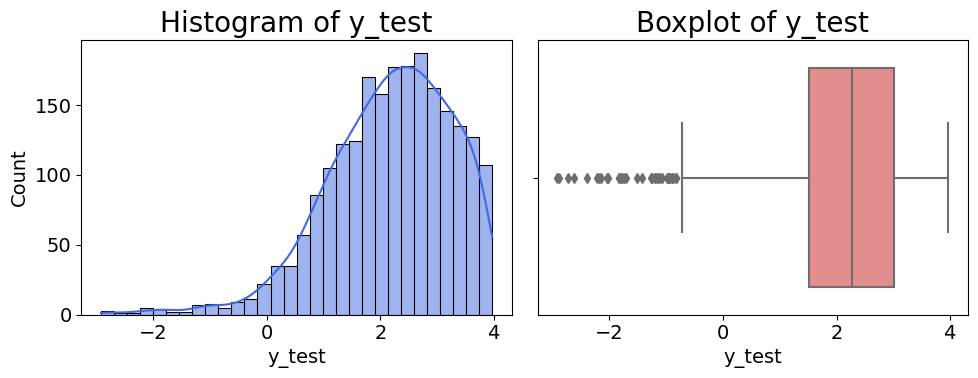

count    2191.000000
mean        2.179943
std         1.100019
min        -2.910563
25%         1.511304
50%         2.279277
75%         3.013251
max         3.966776
Skewness : -0.828
Kurtosis :  1.180


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns                # you said you like seaborn + matplotlib
import pandas as pd
import numpy as np

# 1️⃣  Wrap in a Series so we get nice describe() output
y = pd.Series(y_test, name="y_test")

# 2️⃣  Figure in your preferred 1×2 layout
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram + KDE
sns.histplot(y, bins="auto", kde=True, ax=axes[0], color="royalblue")
axes[0].set_title("Histogram of y_test")
axes[0].set_xlabel("y_test")
axes[0].set_ylabel("Count")

# Box-and-whisker
sns.boxplot(x=y, ax=axes[1], color="lightcoral")
axes[1].set_title("Boxplot of y_test")
axes[1].set_xlabel("y_test")

plt.tight_layout()
plt.show()

# 3️⃣  Numeric summary
print(y.describe().to_string())
print(f"Skewness : {y.skew(): .3f}")
print(f"Kurtosis : {y.kurtosis(): .3f}")


AUC-ROC on test set      : 0.985
Optimal score threshold  : -0.928

Confusion matrix (test):
[[1983  134]
 [   4   70]]
              precision    recall  f1-score   support

     No-Help       1.00      0.94      0.97      2117
        Help       0.34      0.95      0.50        74

    accuracy                           0.94      2191
   macro avg       0.67      0.94      0.73      2191
weighted avg       0.98      0.94      0.95      2191



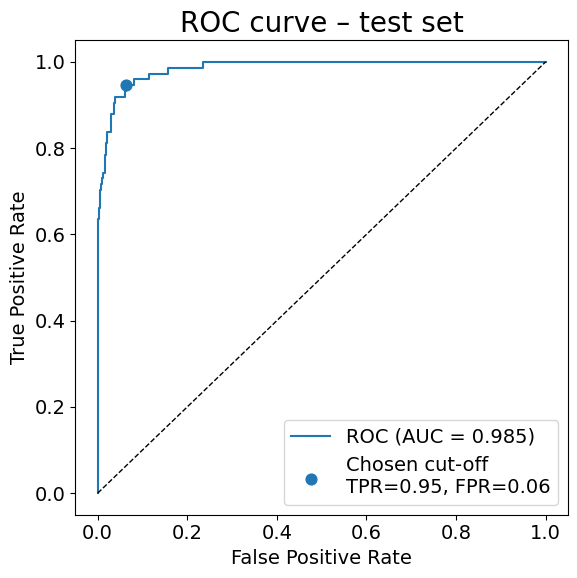

In [23]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 1️⃣  Ground-truth binary label on the TEST window
#     Any *actual* value < help_gt_threshold ⇒ student needs help
# ─────────────────────────────────────────────────────────────
help_gt_threshold = 0                       # adjust if desired
y_test_bin = (y_test <= help_gt_threshold).astype(int)

# ─────────────────────────────────────────────────────────────
# 2️⃣  Model scores on the test set
#     Lower predictions ⇒ more help needed, so flip the sign
# ─────────────────────────────────────────────────────────────
y_pred = random_search.predict(X_test)
scores = -y_pred                             # larger = higher risk

# ─────────────────────────────────────────────────────────────
# 3️⃣  ROC curve & AUC on TEST data
# ─────────────────────────────────────────────────────────────
fpr, tpr, thresh = roc_curve(y_test_bin, scores)
test_auc = auc(fpr, tpr)

# Pick cut-off via Youden J (maximises TPR − FPR)
best_idx       = np.argmax(tpr - fpr)
best_threshold = thresh[best_idx]

print(f"AUC-ROC on test set      : {test_auc:.3f}")
print(f"Optimal score threshold  : {best_threshold:.3f}")

# ─────────────────────────────────────────────────────────────
# 4️⃣  Optional: confusion matrix & quick ROC plot
# ─────────────────────────────────────────────────────────────
y_pred_bin = (scores >= best_threshold).astype(int)

print("\nConfusion matrix (test):")
print(confusion_matrix(y_test_bin, y_pred_bin))
print(classification_report(y_test_bin, y_pred_bin,
                            target_names=['No-Help', 'Help']))

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.scatter(fpr[best_idx], tpr[best_idx], s=60,
            label=f'Chosen cut-off\nTPR={tpr[best_idx]:.2f}, FPR={fpr[best_idx]:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve – test set')
plt.legend()
plt.tight_layout()
plt.show()


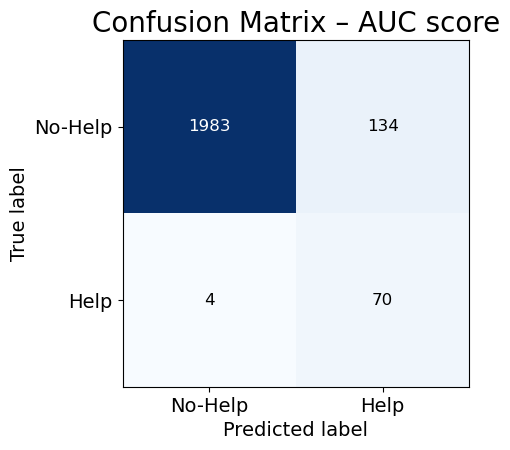

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure the requisite arrays exist
try:
    y_test_bin
    y_pred_bin
except NameError as e:
    raise NameError("Run the cell that defines `y_test_bin` and `y_pred_bin` before this one.") from e

# Confusion matrix
cm = confusion_matrix(y_test_bin, y_pred_bin, labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 5))

# Use a blue colormap, per the user's request
im = ax.imshow(cm, cmap='Blues')

# Axis ticks and labels
class_names = ['No-Help', 'Help']
ax.set_xticks([0, 1], class_names)
ax.set_yticks([0, 1], class_names)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – AUC score")

# Annotate counts – make the (0,0) cell white text
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if (i == 0 and j == 0) else "black"
        ax.text(j, i, cm[i, j],
                ha='center', va='center',
                fontsize=12, color=color)



plt.tight_layout()
plt.show()



Average Precision (area under PR curve): 0.837

★ Best F-1 = 0.764  at score ≥ 0.095
[[2115    2]
 [  27   47]]
              precision    recall  f1-score   support

     No-Help       0.99      1.00      0.99      2117
        Help       0.96      0.64      0.76        74

    accuracy                           0.99      2191
   macro avg       0.97      0.82      0.88      2191
weighted avg       0.99      0.99      0.99      2191


★ Best F-2 = 0.771  at score ≥ -0.516
[[2073   44]
 [  12   62]]
              precision    recall  f1-score   support

     No-Help       0.99      0.98      0.99      2117
        Help       0.58      0.84      0.69        74

    accuracy                           0.97      2191
   macro avg       0.79      0.91      0.84      2191
weighted avg       0.98      0.97      0.98      2191



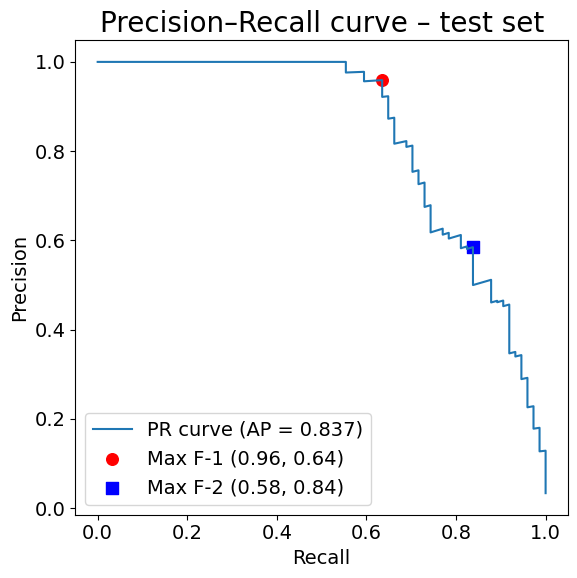

In [25]:
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────
# 0️⃣  Assumes you already have:
#     • scores  = -random_search.predict(X_test)
#     • y_test_bin (0/1 label based on help_gt_threshold)
# ─────────────────────────────────────────────────────────────

# PR curve
precision, recall, pr_thresh = precision_recall_curve(y_test_bin, scores)
avg_prec = average_precision_score(y_test_bin, scores)

# Helper to compute F-β across the curve
def f_beta_score(prec, rec, beta):
    beta_sq = beta**2
    return (1 + beta_sq) * prec * rec / (beta_sq * prec + rec + 1e-12)

# Optimum for β = 1  (F-1)
f1_arr      = f_beta_score(precision, recall, beta=1)
idx_f1      = np.argmax(f1_arr)
thr_f1      = pr_thresh[idx_f1]

# Optimum for β = 2  (F-2, recall-heavy)
f2_arr      = f_beta_score(precision, recall, beta=2)
idx_f2      = np.argmax(f2_arr)
thr_f2      = pr_thresh[idx_f2]

print(f"\nAverage Precision (area under PR curve): {avg_prec:.3f}")

# ── F-1 diagnostics
print(f"\n★ Best F-1 = {f1_arr[idx_f1]:.3f}  at score ≥ {thr_f1:.3f}")
y_pred_f1 = (scores >= thr_f1).astype(int)
print(confusion_matrix(y_test_bin, y_pred_f1))
print(classification_report(y_test_bin, y_pred_f1,
                            target_names=['No-Help', 'Help']))

# ── F-2 diagnostics
print(f"\n★ Best F-2 = {f2_arr[idx_f2]:.3f}  at score ≥ {thr_f2:.3f}")
y_pred_f2 = (scores >= thr_f2).astype(int)
print(confusion_matrix(y_test_bin, y_pred_f2))
print(classification_report(y_test_bin, y_pred_f2,
                            target_names=['No-Help', 'Help']))

# ─────────────────────────────────────────────────────────────
# Plot PR curve with both optimal points
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_prec:.3f})')
plt.scatter(recall[idx_f1], precision[idx_f1],
            s=70, c='red', marker='o',
            label=f'Max F-1 ({precision[idx_f1]:.2f}, {recall[idx_f1]:.2f})')
plt.scatter(recall[idx_f2], precision[idx_f2],
            s=70, c='blue', marker='s',
            label=f'Max F-2 ({precision[idx_f2]:.2f}, {recall[idx_f2]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall curve – test set')
plt.legend()
plt.tight_layout()
plt.show()


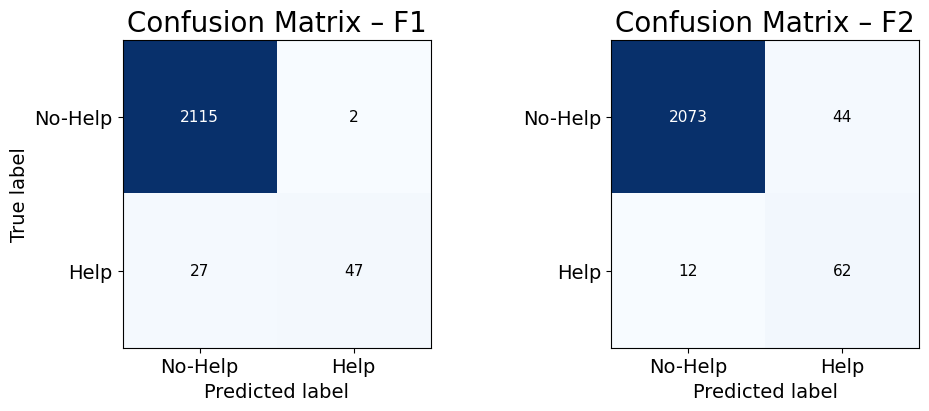

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure the requisite arrays exist
missing = [name for name in ["y_test_bin", "y_pred_f1", "y_pred_f2"] if name not in globals()]
if missing:
    raise NameError(f"Please run the preceding cells to define {missing} before plotting.") from None

cm_f1 = confusion_matrix(y_test_bin, y_pred_f1, labels=[0, 1])
cm_f2 = confusion_matrix(y_test_bin, y_pred_f2, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

class_names = ["No-Help", "Help"]

# Left panel (F-1 threshold)
im1 = axes[0].imshow(cm_f1, cmap="Blues")
axes[0].set_title("Confusion Matrix – F1")
axes[0].set_xticks([0, 1], class_names)
axes[0].set_yticks([0, 1], class_names)
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

# Right panel (F-2 threshold)
im2 = axes[1].imshow(cm_f2, cmap="Blues")
axes[1].set_title("Confusion Matrix – F2")
axes[1].set_xticks([0, 1], class_names)
axes[1].set_yticks([0, 1], class_names)
axes[1].set_xlabel("Predicted label")

# Annotate counts, making the (0,0) cell on the left matrix white text
for i in range(2):
    for j in range(2):
        # Left matrix
        color_left = "white" if (i == 0 and j == 0) else "black"
        axes[0].text(j, i, cm_f1[i, j], ha="center", va="center", fontsize=11, color=color_left)
        # Right matrix (keep all text black)
        axes[1].text(j, i, cm_f2[i, j], ha="center", va="center", fontsize=11,color=color_left)


plt.show()


Confidence interval: [0.38663273351411676, 0.41802284227447944]


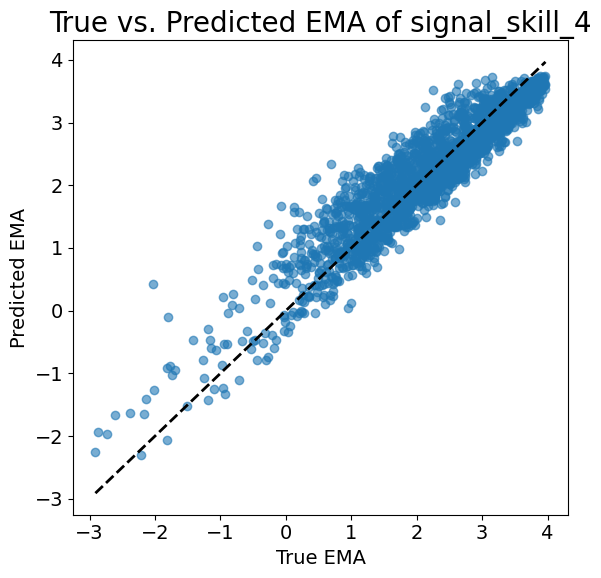

In [27]:
from scipy import stats

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval


print(f"Confidence interval: {[rmse_lower, rmse_upper]}")

# 7) (optional) plot true vs. pred
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("True EMA")
plt.ylabel("Predicted EMA")
#plt.title("True vs. Predicted EMA of max_ema_signal_5min")
plt.title("True vs. Predicted EMA of signal_skill_4")
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd

# 1) Convert y_pred into a Series aligned with y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# 2) Compute absolute errors
errors = (y_test - y_pred_series).abs()

# 3) Find the top 10 largest errors
top10 = errors.sort_values(ascending=False).head(10)

# 4) Build a DataFrame showing true, predicted, and error
results = pd.DataFrame({
    'true':      y_test.loc[top10.index],
    'predicted': y_pred_series.loc[top10.index],
    'error':     top10
})

print(results)

# 5) (Optional) inspect the feature rows for those points
print("\nFeatures for the top 10 errors:")
print(X_test.loc[top10.index])

rows_to_save = X_test.loc[top10.index]

# save to an Excel file in /mnt/data
rows_to_save.to_excel('student8/top10_error_rows.xlsx', index=True)


           true  predicted     error
22110 -2.037394   0.421917  2.459311
21607 -0.069708   1.675022  1.744730
21797 -1.797457  -0.101579  1.695878
21970  0.452507   2.116435  1.663928
21635 -0.275543   1.383132  1.658675
21636  0.407120   2.062163  1.655043
21864  0.690033   2.330869  1.640835
21793  0.121795   1.645982  1.524187
21006 -0.442749   1.032003  1.474752
21767  0.126580   1.577349  1.450769

Features for the top 10 errors:
       first_ans_time  skill_specified_time  level_begin  level_end  grade  \
22110        6.000000                 120.0            4          3     11   
21607      163.333333                 240.0            0          1     10   
21797       93.000000                 300.0            3          2      9   
21970        7.000000                 120.0            3          4     11   
21635       42.000000                 180.0            0          2     10   
21636       21.000000                 120.0            4          4     10   
21864       17

In [29]:
# 1) Best CV RMSE is just the negation of best_score_
best_rmse = -random_search.best_score_
print(f"Best CV RMSE: {best_rmse:.3f}")

# 2) Bring cv results into a DataFrame
cv_results = pd.DataFrame(random_search.cv_results_)

# 3) Since mean_test_score is already neg_RMSE, just negate:
cv_results['mean_rmse'] = -cv_results['mean_test_score']

# 4) std_test_score is std of neg_RMSE, which equals std of RMSE:
cv_results['std_rmse'] = cv_results['std_test_score']

# 5) View top models
print(
    cv_results
    .sort_values('mean_rmse')
    [['params','mean_rmse','std_rmse']]
    .head(5)
)

Best CV RMSE: 0.443
                                               params  mean_rmse  std_rmse
35  {'regressor__max_depth': 15, 'regressor__max_f...   0.443237  0.031360
43  {'regressor__max_depth': 50, 'regressor__max_f...   0.444228  0.033084
48  {'regressor__max_depth': 15, 'regressor__max_f...   0.445304  0.032920
30  {'regressor__max_depth': 35, 'regressor__max_f...   0.448776  0.034470
9   {'regressor__max_depth': 15, 'regressor__max_f...   0.455071  0.033966


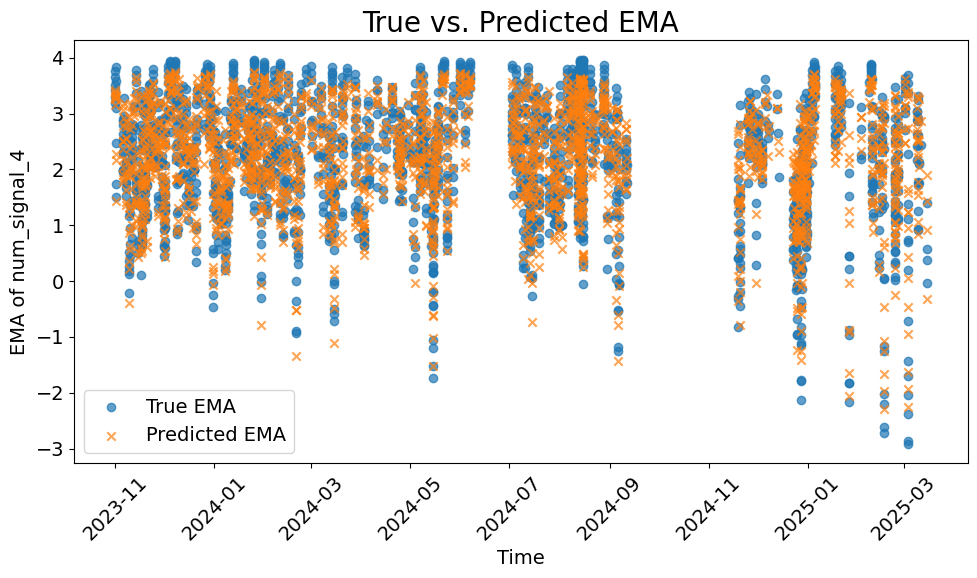

In [30]:
import matplotlib.pyplot as plt

# If you have a datetime index, you can use it for x; otherwise use the integer index
# Here we assume test_df has a datetime column 'start_time'
x = test_df['start_time']

plt.figure(figsize=(10, 6))
plt.scatter(x, y_test,    label='True EMA',      alpha=0.7, marker='o')
plt.scatter(x, y_pred,    label='Predicted EMA', alpha=0.7, marker='x')

plt.xlabel('Time')
plt.ylabel('EMA of num_signal_4')
plt.title('True vs. Predicted EMA')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

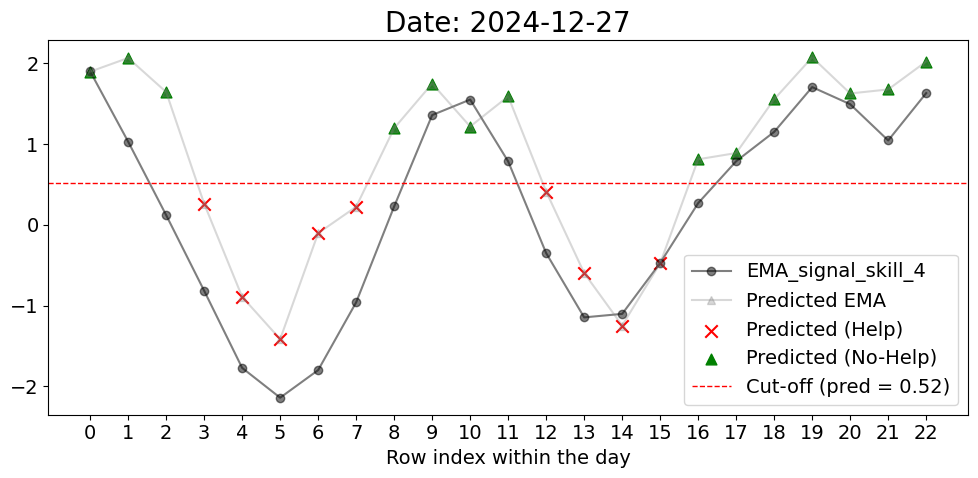

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator

# ──────────────────────────────────────────────────────────────
# 0️⃣  ASSUMPTIONS
#     • test_df, y_test, y_pred already exist
#     • best_score_threshold  = score cut-off chosen earlier
#       (e.g., best_pr_threshold, thr_f2, etc.)
# ──────────────────────────────────────────────────────────────

best_score_threshold =-0.516 #-1.123#-0.878 #-0.389            # ←  put your variable here

# 1️⃣  Pick the day
day_to_plot = '2024-12-27'
day_to_plot = pd.to_datetime(day_to_plot).date()

# 2️⃣  Mask for that day
mask_day = test_df['date'] == day_to_plot
if not mask_day.any():
    raise ValueError(f'No rows found for {day_to_plot} in test_df.')

# 3️⃣  Align series
y_true_day     = y_test.loc[mask_day]
y_pred_series  = pd.Series(y_pred, index=X_test.index)
y_pred_day     = y_pred_series.loc[mask_day]
y_orig_day     = test_df.loc[mask_day, 'signal_skill_4']
x_idx          = range(len(y_true_day))

# 4️⃣  Decision rule  →  Need help if  -pred ≥ best_score_threshold
need_help_mask = (-y_pred_day >= best_score_threshold)

# Pred-space cut-off line (pred ≤ −thr)
pred_cut_line  = -best_score_threshold

# 5️⃣  Plot
plt.figure(figsize=(10, 5))

# True curve
plt.plot(x_idx, y_true_day, linestyle='-', marker='o',
         color='black', alpha=0.5, label='EMA_signal_skill_4')

#Predicted points: colour by decision
plt.plot(x_idx, y_pred_day, linestyle='-', alpha=0.3, color='gray',marker='^',label='Predicted EMA')   # thin guide line
plt.scatter([i for i, h in zip(x_idx, need_help_mask) if h],
            y_pred_day[need_help_mask],
            color='red',   marker='x',  s=80, label='Predicted (Help)')
plt.scatter([i for i, h in zip(x_idx, need_help_mask) if not h],
            y_pred_day[~need_help_mask],
            color='green',  marker='^',  s=60, label='Predicted (No-Help)')

# Original raw signal
# plt.plot(x_idx, y_orig_day, linestyle='--', marker='s',
#          alpha=0.5, label='signal_skill_4')

# Horizontal cut-off line
plt.axhline(pred_cut_line, color='red', linestyle='--',
            linewidth=1, label=f'Cut-off (pred = {pred_cut_line:.2f})')

ax = plt.gca()                       # get the current Axes
ax.xaxis.set_major_locator(MultipleLocator(1))   # tick at every integer
ax.set_xticks(range(len(x_idx)))
ax.set_xticklabels(x_idx)

plt.xlabel('Row index within the day')
plt.title(f'Date: {day_to_plot}')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Safety / existence checks ----------------------------------------------
try:
    df_interval
except NameError as e:
    raise NameError(
        "`df_interval` isn’t defined in this notebook session. "
        "Run the cell that builds it (filtering by start/end date), then rerun this one."
    ) from e

# ---- CONFIG ------------------------------------------------------------------
best_score_threshold = -1.8  # risk cut-off  (−pred ≥ thr)
pred_cut_line        = -best_score_threshold  # y-value of horizontal threshold

# Use EMA as “prediction” for demo; adjust if you have a different y_pred
y_pred = df_interval["ema_signal_4"].values
need_help_mask = (-y_pred >= best_score_threshold)

# ---- Build the figure --------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

x_vals = df_interval.index

# Raw signal
ax.plot(
    x_vals,
    df_interval["signal_skill_4"],
    marker="x",
    linestyle="-",
    label="signal_skill_4",
)

# EMA / prediction
ax.plot(
    x_vals,
    y_pred,
    #marker="o",
    linestyle="-",
    alpha=0.5,
    color="gray",
    label="ema_signal_4",
)

# Scatter points coloured by decision rule
ax.scatter(
    x_vals[need_help_mask],
    y_pred[need_help_mask],
    color="red",
    marker="^",
    s=100,
    label="Help",
)
ax.scatter(
    x_vals[~need_help_mask],
    y_pred[~need_help_mask],
    color="green",
    marker="^",
    s=80,
    label="No-Help",
)

# Horizontal threshold line
ax.axhline(
    pred_cut_line,
    color="black",
    linestyle="--",
    linewidth=1.2,
    label=f"Threshold = {pred_cut_line:.3f}",
)

# ---- Axis labels / title -----------------------------------------------------
ax.set_xlabel("Index")
#ax.set_ylabel("Signal value")
ax.set_title("Signal & EMA with help/no-help decision threshold")

# integer tick positions every 10 rows
tick_positions = np.arange(min(x_vals), max(x_vals) + 1, 10)
ax.set_xticks(tick_positions)

# labels: corresponding start_time dates (YYYY-MM-DD only)
ax.set_xticklabels(
    df_interval.loc[tick_positions, 'start_time'].dt.date.astype(str),
    rotation=45, ha='right'
)


# Optional: y-axis integer ticks if the range is small
y_min = int(np.floor(min(df_interval[["signal_skill_4"]].min())))
y_max = int(np.ceil(max(df_interval[["signal_skill_4"]].max())))
ax.set_yticks(np.arange(y_min, y_max + 1, 1))

ax.legend( bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()


In [ ]:
# Boolean mask on the one-day Series
need_help_mask = (-y_pred_day >= best_score_threshold)

# Row labels (indices) that meet the threshold
flag_idx = need_help_mask.index[need_help_mask]

# Pull the skill column for just those rows
skills_needing_help = test_df.loc[flag_idx, 'skill']

print("Skills needing help (row order, repeats kept):")
print(skills_needing_help.tolist())
# All columns for rows that need help on the chosen day
need_help_rows = test_df.loc[flag_idx]      # flag_idx from the previous step
need_help_rows



In [ ]:
# Make sure both sides of the comparison are plain Python dates
day_dt   = pd.to_datetime(day_to_plot).date()   # '2024-12-27' → datetime.date
mask_day = test_df['date'] == day_dt            # Boolean mask

# Slice the full DataFrame for that day
day_records = test_df.loc[mask_day]

# Show every column for every row on that day
day_records         # or simply `day_records` in a Jupyter cell


In [ ]:
import pandas as pd
import numpy as np

# ──────────────────────────────────────────────────────────────
# CONFIG
# ──────────────────────────────────────────────────────────────
best_score_threshold = -0.316          # risk cut-off  (−y_pred ≥ thr)
day_to_plot          = '2024-12-27'    # calendar day of interest
lookback_days        = 0               # window size (days)
# ──────────────────────────────────────────────────────────────

# --- 0. Align model outputs ---------------------------------------------------
y_pred_series = pd.Series(y_pred, index=X_test.index)
scores        = -y_pred_series        # higher value ⇒ riskier

# --- 1. Renumber rows inside each day -----------------------------------------
test_df = (
    test_df
      .sort_values(['date', 'start_time'])        # guarantees chronological order
      .copy()
)
test_df['daily_index'] = test_df.groupby('date').cumcount()   # 0,1,2,…

# --- 2. Flag rows (by daily index) needing help --------------------------------
day_dt     = pd.to_datetime(day_to_plot).date()
mask_day   = test_df['date'] == day_dt
need_help  = (scores >= best_score_threshold) & mask_day

flag_rows = test_df.loc[need_help, ['start_time', 'skill', 'daily_index']]
if flag_rows.empty:
    raise ValueError('No rows on that date were flagged for help.')

# --- 3. Build per-flagged-row, per-skill contributions ------------------------
records = []

for ridx, r in flag_rows.iterrows():
    idx_time   = r['start_time']
    idx_seq    = r['daily_index']             # ← index _within_ the day
    win_start  = idx_time - pd.Timedelta(days=lookback_days)

    # rows on the same day, earlier (or equal) daily_index, inside look-back window
    same_day       = test_df['date'] == day_dt
    prior_in_day   = test_df['daily_index'] <= idx_seq
    win_mask = (
        same_day & prior_in_day &
        (test_df['start_time'] >= win_start) &
        (test_df['start_time'] <= idx_time)
    )

    win_df     = test_df.loc[win_mask, ['skill']]
    win_scores = scores.loc[win_mask]

    # accumulate risk for *this* flagged row
    for skill_name, rows in win_df.groupby('skill').groups.items():
        records.append({
            'flagged_index': (day_dt, idx_seq),   # (date, position-in-day)
            'skill':           skill_name,
            'risk_contribution': -win_scores.loc[rows].sum()
        })

contrib_long = pd.DataFrame(records)
all_skills   = test_df['skill'].unique()

# --- 4. Wide matrix – keep NaNs, then prune all-NaN cols/rows ------------------
contrib_wide = (
    contrib_long
      .pivot_table(index='flagged_index', columns='skill',
                   values='risk_contribution', aggfunc='sum')
      .reindex(columns=all_skills)           # ensure full skill list
)
contrib_wide = contrib_wide.dropna(axis=1, how='all')   # drop skills never present
contrib_wide = contrib_wide.dropna(axis=0, how='all')   # drop empty flagged rows

print('\nWide matrix (all-NaN skills & rows removed):')
display(contrib_wide)

# --- 5. Long view – only non-NaN entries --------------------------------------
contrib_long_full = (
    contrib_wide
      .stack(dropna=True)           # flatten, omit NaNs
      .rename('risk_contribution')
      .reset_index()
      .rename(columns={'level_0': 'flagged_index'})
)

print('\nLong format (non-NaN contributions only):')
display(contrib_long_full.sort_values(['flagged_index', 'risk_contribution'],
                                      ascending=[True, False]))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Safety check -------------------------------------------------------------
try:
    contrib_wide
except NameError as e:
    raise NameError(
        "The DataFrame `contrib_wide` is not defined in this session. "
        "Run the cell that builds it, then rerun this visualization."
    ) from e

# --- Prepare data -------------------------------------------------------------
# Use only the daily_index (2nd element of tuple) for the x-axis
plot_df = contrib_wide.copy()
plot_df['daily_index'] = [
    idx[1] if isinstance(idx, tuple) and len(idx) == 2 else idx
    for idx in plot_df.index
]
plot_df = (
    plot_df
      .set_index('daily_index')
      .sort_index()
      .fillna(0)            # NaN → 0 so bars line up
)

# If there are more than 3 skills, pick the three with the largest total risk
skill_cols = (
    plot_df.sum(axis=0)
            .sort_values(ascending=False)
            .head(3)
            .index
            .tolist()
)

plot_df_sel = plot_df[skill_cols]

# --- Grouped bar chart --------------------------------------------------------
x = np.arange(len(plot_df_sel.index))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(12, 5))

for i, skill in enumerate(skill_cols):
    ax.bar(
        x + i * bar_width,
        plot_df_sel[skill].values,
        bar_width,
        label=skill
    )

# Horizontal reference line at y = 0 (baseline)
ax.axhline(0, color='black', linewidth=1.0, linestyle='--')

ax.set_xlabel("Flagged row index within day")
ax.set_ylabel("Risk contribution")
ax.set_title("Risk contributions by skill")
ax.set_xticks(x + bar_width * (len(skill_cols)-1) / 2)
ax.set_xticklabels(plot_df_sel.index.astype(str))
ax.legend(title="Skill", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# --- Show the underlying table for reference ---------------------------------
plot_df_sel


Top 10 features by importance:
num__ema_signal_4_lag2      0.252341
num__deltaPI_skill_past2    0.116285
ord__deltaPI_skill_past1    0.083342
ord__deltaPI_day_past1      0.076769
num__num_wrong_responses    0.056066
ord__first_resp             0.036417
num__PI_skill               0.034426
ord__first_resp             0.033430
num__consec_wrong_day       0.032593
num__cum_wrong_sess         0.031762
dtype: float64


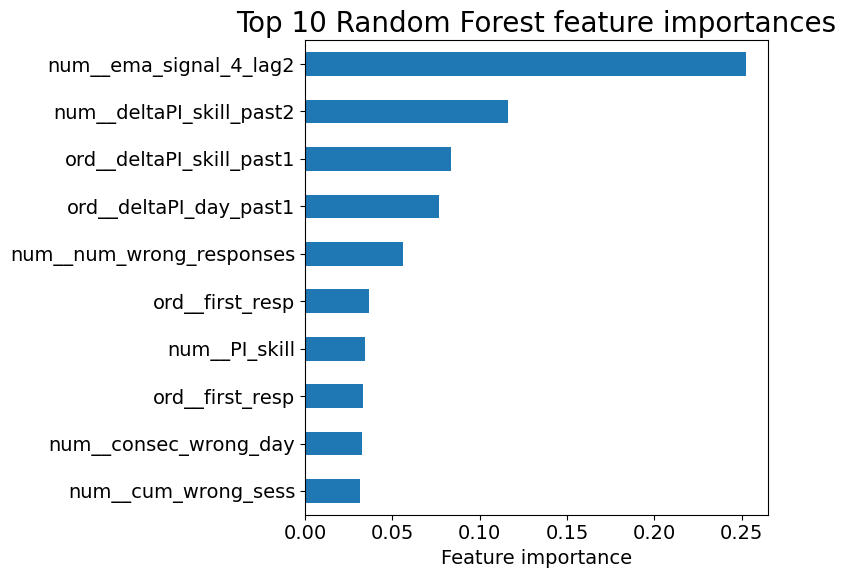

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the fitted pipeline
rf_pipeline = random_search.best_estimator_

# 2) Extract the trained RandomForestRegressor
rf = rf_pipeline.named_steps['regressor']

# 3) Get the transformed feature names from the preprocessor
#    (requires sklearn ≥1.0)
feat_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 4) Build a Series of importances
feat_imp = pd.Series(rf.feature_importances_, index=feat_names)
feat_imp = feat_imp.sort_values(ascending=False)

# 5) Peek at the top 10
print("Top 10 features by importance:")
print(feat_imp.head(10))

# 6) (Optional) bar-plot the top 10
plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Top 10 Random Forest feature importances")
plt.tight_layout()
plt.show()


## Nested

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.base import clone

# ──────────────────────────────────────────────────────────────
# Assumes X_train, y_train, pipeline, param_dist already exist
# If they don't, run the previous setup cells first.
# ──────────────────────────────────────────────────────────────

help_gt_threshold = -1        # y_true < threshold ⇒ needs help
n_outer_splits    = 3
n_inner_splits    = 5
n_iter_random     = 50

outer_tscv  = TimeSeriesSplit(n_splits=n_outer_splits)
inner_tscv  = TimeSeriesSplit(n_splits=n_inner_splits)

all_scores  = []   # -prediction scores (higher = more help needed)
all_labels  = []   # 0/1 ground truth for "needs help"

for train_idx, val_idx in outer_tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Inner hyper-parameter search (RMSE criterion)
    search = RandomizedSearchCV(
        estimator=clone(pipeline),
        param_distributions=param_dist,
        n_iter=n_iter_random,
        cv=inner_tscv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    search.fit(X_tr, y_tr)

    # Scores on the outer-fold validation slice
    y_val_pred = search.best_estimator_.predict(X_val)
    score_slice = -y_val_pred                      # lower y ⇒ more help → negate
    label_slice = (y_val < help_gt_threshold).astype(int)

    all_scores.append(score_slice)
    all_labels.append(label_slice)

# Concatenate all outer-fold slices
scores = np.concatenate(all_scores)
labels = np.concatenate(all_labels)

# ROC curve + AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Optimal cut-off via Youden J (maximises TPR − FPR)
best_idx       = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

print(f"AUC-ROC = {roc_auc:.3f}")
print(f"Optimal threshold on -prediction score = {best_threshold:.3f}")

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', s=60,
            label=f'Optimal cut-off\nTPR={tpr[best_idx]:.2f}, FPR={fpr[best_idx]:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nested CV ROC Curve\nRegression-to-Intervention Scores')
plt.legend()
plt.tight_layout()
plt.show()
